# Llama 3.2 Vision: 2-Turn Balance-Description Bank Statement Extraction

**Protocol**: Two independent single-turn prompts + Python parsing/filtering

**Key Insight**: Balance-description prompt works for BOTH date-per-row AND date-grouped formats!

---

## Complete Workflow

```
Turn 0: Image + Prompt → Headers (fresh context)
        ↓ (Python pattern matching)
        ↓ (Check if Balance column exists)
Turn 1: Image + Prompt → Balance-Description extraction (fresh context)
        ↓ (Python parsing + filtering)
Schema Fields: TRANSACTION_DATES, LINE_ITEM_DESCRIPTIONS, TRANSACTION_AMOUNTS_PAID
```

### Pipeline Stages:
1. **Turn 0 (LLM)**: Identify column headers from image
2. **Pattern Matching (Python)**: Map headers to concepts (Date, Description, Debit, Credit, Balance)
3. **Turn 1 (LLM)**: Extract using balance-description prompt (works for all date formats)
4. **Python Parsing**: Parse hierarchical output → Filter for debits → Extract schema fields

### Why Balance-Description Works:
- **Anchors extraction to Balance column** - unambiguous reference point
- **Works for date-per-row**: Each transaction gets its date
- **Works for date-grouped**: Date headers naturally map to transactions
- **No format classification needed** - eliminates Turn 0.5 entirely!

### Key Advantages over 3-Turn Table Extraction:
- ✅ **Simpler pipeline** - 2 turns instead of 3
- ✅ **No format classification** - works universally
- ✅ **Balance-anchored** - reduces debit/credit confusion
- ✅ **Hierarchical output** - easier to parse date groupings

In [1]:
# Cell 1: Imports
import os
os.environ["CUBLAS_WORKSPACE_CONFIG"] = ":4096:8"

# Add parent directory to path AND change working directory for config file resolution
import sys
from pathlib import Path

# Get project root (parent of bank_statement/)
project_root = Path.cwd().parent
sys.path.insert(0, str(project_root))

# Change working directory to project root so config/field_definitions.yaml is found
os.chdir(project_root)
print(f"📁 Working directory: {os.getcwd()}")

# Standard library imports
import random
import re

# Third-party imports
import numpy as np
import torch
from PIL import Image
from transformers import AutoProcessor, MllamaForConditionalGeneration
from IPython.display import display, Markdown, HTML
from common.reproducibility import set_seed, configure_deterministic_mode
set_seed(42)
configure_deterministic_mode(True) 

📁 Working directory: /home/jovyan/nfs_share/tod/LMM_POC
✅ Random seed set to 42 for reproducibility
✅ PyTorch deterministic mode enabled
⚠️  Note: May reduce performance


# Load the model

In [2]:
# Cell 3: Load Llama-3.2-Vision model
# Update this path to your local Llama model
model_id = "/home/jovyan/nfs_share/models/Llama-3.2-11B-Vision-Instruct"

print("🔧 Loading Llama-3.2-Vision model...")

from common.llama_model_loader_robust import load_llama_model_robust

model, processor = load_llama_model_robust(
    model_path=model_id,
    use_quantization=False,
    device_map='auto',
    max_new_tokens=4096,  # Increased for balance-description output
    torch_dtype='bfloat16',
    low_cpu_mem_usage=True,
    verbose=True
)

# Add tie_weights() call
try:
    model.tie_weights()
    print("✅ Model weights tied successfully")
except Exception as e:
    print(f"⚠️ tie_weights() warning: {e}")

🔧 Loading Llama-3.2-Vision model...


🚀 Loading Llama Vision model with robust multi-GPU optimization...

Features: Smart quantization, memory management, V100 support

🔧 Configuring CUDA memory for Llama...

🔧 CUDA memory allocation configured: max_split_size_mb:64
💡 Using 64MB memory blocks to reduce fragmentation
📊 Initial CUDA state: Allocated=0.00GB, Reserved=0.00GB


🔍 Performing robust GPU memory detection...

🔍 Starting robust GPU memory detection...
📊 Detected 1 GPU(s), analyzing each device...
   GPU 0 (NVIDIA L4): 22.0GB total, 22.0GB available

🔍 ROBUST GPU MEMORY DETECTION REPORT
✅ Success: 1/1 GPUs detected
📊 Total Memory: 21.95GB
💾 Available Memory: 21.95GB
⚡ Allocated Memory: 0.00GB
🔄 Reserved Memory: 0.00GB
📦 Fragmentation: 0.00GB
🖥️  Multi-GPU: No
⚖️  Balanced Distribution: Yes

📋 Per-GPU Breakdown:
   GPU 0 (NVIDIA L4): 22.0GB total, 22.0GB available (0.0% used)


📊 GPU Hardware: NVIDIA L4 (1x 22GB = 22GB total)

🏗️ Architecture: cloud_inference (dynamic detection)

🎯 Model: Llama-3.2-11B-Vision (full precision: 22.0GB, threshold: 24.0GB)

💾 Available Memory: 22.0GB across 1 GPU(s)

💡 Memory sufficient: ❌ No

✅ Cloud inference GPU with 22GB - running in full precision as requested

📊 FINAL QUANTIZATION DECISION: DISABLED (full precision)

   Total GPU Memory: 22GB

   Available Memory: 22GB

Full precision needs: 22.0GB + 2.0GB buffer = 24.0GB threshold

   Working GPUs: 1/1

🚀 Using 16-bit precision for optimal performance

Loading Llama Vision model...

The argument `trust_remote_code` is to be used with Auto classes. It has no effect here and is ignored.


Loading checkpoint shards:   0%|          | 0/5 [00:00<?, ?it/s]

Some parameters are on the meta device because they were offloaded to the cpu.


Loading processor...

✅ Model and processor loaded successfully!

📊 Single GPU Analysis:

   Device: cuda:0

   GPU: NVIDIA L4

   Memory: 19.79GB allocated, 20.09GB reserved, 24GB total

                            🔧 Llama Vision Model Configuration                            
┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Setting             ┃ Value                         ┃ Llama Status                      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ Model Path          │ Llama-3.2-11B-Vision-Instruct │ ✅ Valid                          │
│ Device Placement    │ cuda:0                        │ ✅ Loaded                         │
│ Quantization Method │ 16-bit                        │ ✅ 16-bit (Performance Optimized) │
│ Data Type           │ bfloat16                      │ ✅ Recommended                    │
│ Max New Tokens      │ 4096                          │ ✅ Generation Ready               │
│ GPU Configuration   │ 1 GPU(s)                      │ ✅ Available                      │
│ Model Parameters    │ 10,670,220,835                │ ✅ Loaded                         │
│ Memory Optimization │ Llama Robust                  │ ✅ V100 Compatible                │
└─────────────────────┴───────────────────────────────┴───────────────────────────────────┘

Running model compatibility test...

✅ Model compatibility test passed

Performing initial memory cleanup...

🧹 Memory cleanup completed

💾 Final state: Allocated=19.79GB, Reserved=20.09GB, Fragmentation=0.30GB

🎉 Llama Vision model loading and validation complete!

🔧 Llama optimizations active: 16-bit precision, memory management, vision preservation

✅ Model weights tied successfully


# Load the image

📁 Loading image...
✅ Image loaded: (767, 886)
✅ Images list created with 1 image(s)
🖼️  Bank statement image:


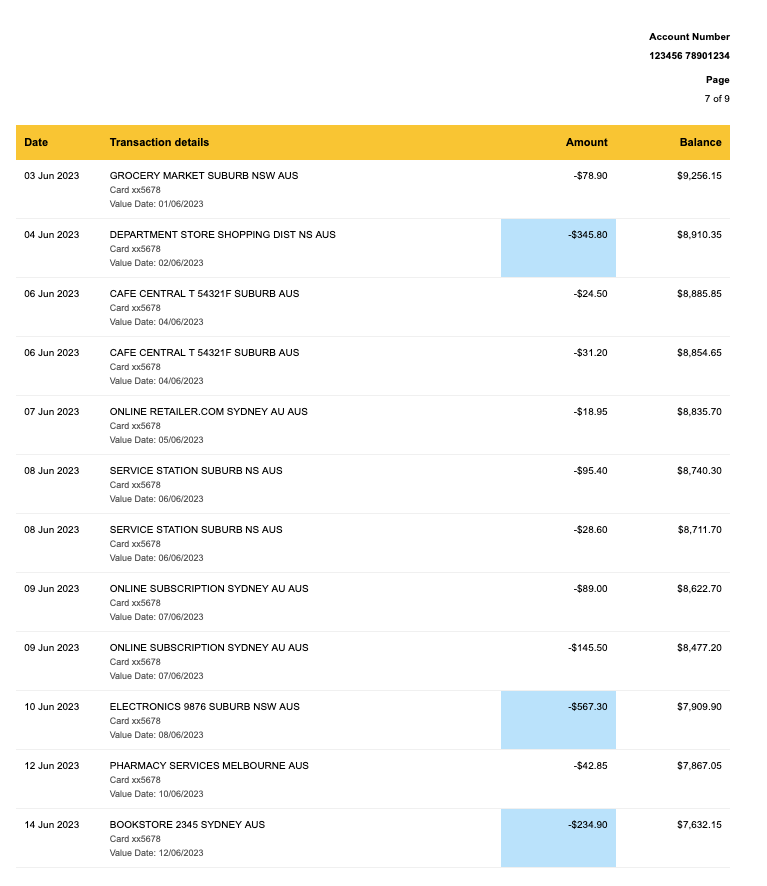

In [3]:
# Cell 5: Load bank statement image
# Update this path to your test image
# imageName = "/home/jovyan/nfs_share/tod/LMM_POC/evaluation_data/bank/minimal/image_003.png"
# imageName = "/home/jovyan/nfs_share/tod/LMM_POC/evaluation_data/bank/minimal/image_009.png"
# imageName = "${HOME}/nfs_share/tod/LMM_POC/evaluation_data/bank/synthetic_chrono.png"
# imageName = str(Path.home() / "nfs_share/tod/LMM_POC/evaluation_data/bank/synthetic_chrono.png")
# imageName = str(Path.home() / "nfs_share/tod/LMM_POC/evaluation_data/bank/synthetic_multiline.png")
imageName = str(Path.home() / "nfs_share/tod/LMM_POC/evaluation_data/bank/cba_amount_balance.png")

print("📁 Loading image...")
image = Image.open(imageName)

# CRITICAL: Store as list for compatibility
images = [image]

print(f"✅ Image loaded: {image.size}")
print(f"✅ Images list created with {len(images)} image(s)")

# Display the loaded image for visual verification
print("🖼️  Bank statement image:")
display(image)

# Bank Statement Extraction Protocol (2-Turn Balance-Description)
- Turn 0: Identify actual table headers
- Turn 1: Extract using balance-description prompt
- Python: Parse, filter, and extract schema fields

In [4]:
# Cell 7: Turn 0 - Identify table headers (prompt)
# TURN 0: Identify Table Headers

prompt = """
Look at the transaction table in this bank statement image.

What are the exact column header names used in the transaction table?

List each column header exactly as it appears, in order from left to right.
Do not interpret or rename them - use the EXACT text from the image.
"""

# Create message structure for Llama
messageDataStructure = [
    {
        "role": "user",
        "content": [
            {"type": "image"},
            {
                "type": "text",
                "text": prompt,
            },
        ],
    }
]

print("💬 TURN 0: Identifying actual table headers")
print("🤖 Generating response with Llama-3.2-Vision...")

💬 TURN 0: Identifying actual table headers
🤖 Generating response with Llama-3.2-Vision...


In [5]:
# Cell 8: Turn 0 - Execute and parse headers

textInput = processor.apply_chat_template(
    messageDataStructure, add_generation_prompt=True
)

inputs = processor(images=images, text=textInput, return_tensors="pt").to(model.device)

output = model.generate(
    **inputs,
    max_new_tokens=500,
    do_sample=False,
    temperature=None,
    top_p=None,
)

generate_ids = output[:, inputs['input_ids'].shape[1]:-1]
turn0_response = processor.decode(generate_ids[0], clean_up_tokenization_spaces=False)

# Free memory
del inputs, output, generate_ids
torch.cuda.empty_cache()

print("✅ Response generated successfully!")
print("\n" + "=" * 60)
print("TURN 0 - IDENTIFIED TABLE HEADERS:")
print("=" * 60)
print(turn0_response)
print("=" * 60)

# Parse the identified headers
header_lines = [line.strip() for line in turn0_response.split('\n') if line.strip()]
identified_headers = []

for line in header_lines:
    cleaned = line.lstrip('0123456789.-•* ').strip()
    cleaned = cleaned.replace('**', '').replace('__', '')
    if cleaned.endswith(':'):
        continue
    if len(cleaned) > 40:
        continue
    if cleaned and len(cleaned) > 2:
        identified_headers.append(cleaned)

print(f"\n📋 Parsed {len(identified_headers)} column headers:")
for i, header in enumerate(identified_headers, 1):
    print(f"  {i}. '{header}'")

# Store for subsequent turns
table_headers = identified_headers
print(f"\n✅ Stored table_headers: {table_headers}")

✅ Response generated successfully!

TURN 0 - IDENTIFIED TABLE HEADERS:
**Transaction Table Column Headers:**

*   **Date**
*   **Transaction details**
*   **Amount**
*   **Balance**

📋 Parsed 4 column headers:
  1. 'Date'
  2. 'Transaction details'
  3. 'Amount'
  4. 'Balance'

✅ Stored table_headers: ['Date', 'Transaction details', 'Amount', 'Balance']


## Pattern Matching: Map Generic Concepts to Actual Headers

Different bank statements use different column names. Use pattern matching to identify:
- Which header represents **Date**
- Which header represents **Description/Details**  
- Which header represents **Debit/Withdrawal**
- Which header represents **Credit/Deposit**
- Which header represents **Balance** (CRITICAL for this approach!)

In [6]:
# Cell 9: Pattern Matching - Map headers to generic columns

DATE_PATTERNS = ['date', 'day', 'transaction date', 'trans date']
DESCRIPTION_PATTERNS = [
    'description', 'details', 'transaction details', 'trans details',
    'particulars', 'narrative', 'transaction', 'trans'
]
DEBIT_PATTERNS = ['debit', 'debits', 'withdrawal', 'withdrawals', 'paid', 'paid out', 'spent', 'dr']
CREDIT_PATTERNS = ['credit', 'credits', 'deposit', 'deposits', 'received', 'cr']
BALANCE_PATTERNS = ['balance', 'bal', 'running balance']
AMOUNT_PATTERNS = ['amount', 'amt', 'value', 'total']

def match_header(headers, patterns, fallback=None):
    """Match a header using pattern keywords."""
    headers_lower = [h.lower() for h in headers]
    
    # Try exact match first
    for pattern in patterns:
        for i, header_lower in enumerate(headers_lower):
            if pattern == header_lower:
                return headers[i]
    
    # Try substring match
    for pattern in patterns:
        if len(pattern) > 2:
            for i, header_lower in enumerate(headers_lower):
                if pattern in header_lower:
                    return headers[i]
    
    return fallback

# Perform pattern matching - detect columns independently
date_col = match_header(table_headers, DATE_PATTERNS, fallback=table_headers[0] if table_headers else 'Date')
desc_col = match_header(table_headers, DESCRIPTION_PATTERNS, fallback=table_headers[1] if len(table_headers) > 1 else 'Description')
amount_col = match_header(table_headers, AMOUNT_PATTERNS, fallback=None)
debit_col = match_header(table_headers, DEBIT_PATTERNS, fallback=None)  # Don't fallback to amount!
credit_col = match_header(table_headers, CREDIT_PATTERNS, fallback=None)  # Don't fallback to amount!
balance_col = match_header(table_headers, BALANCE_PATTERNS, fallback=None)

# Detect column presence
has_balance = balance_col is not None and balance_col in table_headers
has_amount = amount_col is not None and amount_col in table_headers
has_debit_or_credit = (debit_col is not None and debit_col in table_headers) or \
                      (credit_col is not None and credit_col in table_headers)

# Strategy selection based on column presence
if has_balance and has_debit_or_credit and not has_amount:
    extraction_strategy = "BALANCE_DESCRIPTION"
    strategy_reason = "Balance + Debit/Credit columns detected"
elif has_balance and has_amount and not has_debit_or_credit:
    extraction_strategy = "AMOUNT_DESCRIPTION"
    strategy_reason = "Balance + Amount column detected (signed values)"
elif has_balance and has_debit_or_credit:
    extraction_strategy = "BALANCE_DESCRIPTION"
    strategy_reason = "Balance + Debit/Credit columns detected"
elif has_amount:
    extraction_strategy = "AMOUNT_DESCRIPTION"
    strategy_reason = "Amount column detected (no balance)"
elif has_debit_or_credit:
    extraction_strategy = "DEBIT_CREDIT_DESCRIPTION"
    strategy_reason = "Debit/Credit columns detected (no balance)"
else:
    extraction_strategy = "TABLE_EXTRACTION"
    strategy_reason = "Fallback to table extraction"

print("=" * 60)
print("PATTERN MATCHING RESULTS:")
print("=" * 60)
print(f"📋 Extracted Headers: {table_headers}")
print(f"\n🔍 Mapped Columns:")
print(f"  Date        → '{date_col}'")
print(f"  Description → '{desc_col}'")
print(f"  Amount      → '{amount_col}'")
print(f"  Debit       → '{debit_col}'")
print(f"  Credit      → '{credit_col}'")
print(f"  Balance     → '{balance_col}'")

print(f"\n🎯 Balance column detected: {'✅ YES' if has_balance else '❌ NO'}")
print(f"🎯 Amount column detected: {'✅ YES' if has_amount else '❌ NO'}")
print(f"🎯 Debit/Credit columns detected: {'✅ YES' if has_debit_or_credit else '❌ NO'}")

print(f"\n📊 Strategy: {extraction_strategy}")
print(f"   Reason: {strategy_reason}")


PATTERN MATCHING RESULTS:
📋 Extracted Headers: ['Date', 'Transaction details', 'Amount', 'Balance']

🔍 Mapped Columns:
  Date        → 'Date'
  Description → 'Transaction details'
  Debit       → 'Amount'
  Credit      → 'Amount'
  Balance     → 'Balance'

🎯 Balance column detected: ✅ YES


## Turn 1: Balance-Description Extraction

This is the key innovation - instead of extracting a markdown table, we ask the model to list all balances with their associated transaction details.

**Prompt Pattern:**
```
List all the balances in the {balance_col} column, including:
- Date from the Date Header of the balance
- {desc_col}
- {debit_col} Amount or "NOT_FOUND"
- {credit_col} Amount or "NOT_FOUND"
```

This produces hierarchical output that's easy to parse and works for both date formats!

In [7]:
# Cell 10: Turn 1 - Extraction Prompt (strategy-based)

extraction_prompt = None

if extraction_strategy == "BALANCE_DESCRIPTION":
    # Standard format: Debit/Credit columns with Balance
    extraction_prompt = f"""List all the balances in the {balance_col} column, including:
- Date from the Date Header of the balance
- {desc_col}
- {debit_col} Amount or "NOT_FOUND"
- {credit_col} Amount or "NOT_FOUND"

Format each balance entry like this:
1. **[Date]**
   - {desc_col}: [ALL rows of text for this transaction]
   - {debit_col}: [amount or NOT_FOUND]
   - {credit_col}: [amount or NOT_FOUND]
   - {balance_col}: [balance amount]

CRITICAL RULES:
1. List EVERY balance entry in order from top to bottom
2. EVERY balance entry has a date, either on the same row, or above
3. Include the FULL {desc_col} text - capture ALL rows that belong to this transaction, not abbreviated
4. If amount is in {debit_col} column, put it there and use NOT_FOUND for {credit_col}
5. If amount is in {credit_col} column, put it there and use NOT_FOUND for {debit_col}
6. Do NOT skip any transactions
"""
    print("📝 TURN 1: Balance-Description Extraction (Debit/Credit format)")

elif extraction_strategy == "AMOUNT_DESCRIPTION":
    # CBA-style format: Single Amount column (signed) with optional Balance
    balance_line = f"- {balance_col}" if has_balance else ""
    balance_format = f"- {balance_col}: [balance amount]" if has_balance else ""
    
    extraction_prompt = f"""List all transactions from this bank statement, including:
- Date
- {desc_col}
- {amount_col} (preserve the sign: negative = withdrawal, positive = deposit)
{balance_line}

Format each entry like this:
1. **[Date]**
   - {desc_col}: [ALL rows of text for this transaction]
   - {amount_col}: [amount with sign preserved]
   {balance_format}

CRITICAL RULES:
1. List EVERY transaction in order from top to bottom
2. EVERY entry has a date, either on the same row, or above
3. Include the FULL {desc_col} text - capture ALL rows, not abbreviated
4. PRESERVE the sign of amounts (negative = withdrawal, positive = deposit)
5. Do NOT skip any transactions
"""
    print("📝 TURN 1: Amount-Description Extraction (signed Amount format)")

else:
    print(f"❌ Strategy {extraction_strategy} not supported in this notebook")
    extraction_prompt = None

if extraction_prompt:
    print("=" * 60)
    print("Extraction Prompt:")
    print(extraction_prompt)
    print("=" * 60)


📝 TURN 1: Balance-Description Extraction
Extraction Prompt:
List all the balances in the Balance column, including:
- Date from the Date Header of the balance
- Transaction details
- Amount Amount or "NOT_FOUND"
- Amount Amount or "NOT_FOUND"

Format each balance entry like this:
1. **[Date]**
   - Transaction details: [ALL rows of text for this transaction]
   - Amount: [amount or NOT_FOUND]
   - Amount: [amount or NOT_FOUND]
   - Balance: [balance amount]

CRITICAL RULES:
1. List EVERY balance entry in order from top to bottom
2. EVERY balance entry has a date, either on the same row, or above
3. Include the FULL description text, not abbreviated
4. If amount is in Amount column, put it there and use NOT_FOUND for Amount
5. If amount is in Amount column, put it there and use NOT_FOUND for Amount
6. Do NOT skip any transactions



In [8]:
# Cell 11: Turn 1 - Execute extraction (INDEPENDENT, fresh context)

if extraction_prompt:
    # CRITICAL: Create FRESH message structure (NOT appending to conversation history)
    messageDataStructure_turn1 = [
        {
            "role": "user",
            "content": [
                {"type": "image"},
                {"type": "text", "text": extraction_prompt}
            ]
        }
    ]
    
    print("🤖 Generating response with Llama-3.2-Vision...")
    
    textInput = processor.apply_chat_template(
        messageDataStructure_turn1, add_generation_prompt=True
    )
    
    inputs = processor(images=images, text=textInput, return_tensors="pt").to(model.device)
    
    output = model.generate(
        **inputs,
        max_new_tokens=4096,  # Increased for balance-description output
        do_sample=False,
        temperature=None,
        top_p=None,
    )
    
    generate_ids = output[:, inputs['input_ids'].shape[1]:-1]
    extraction_response = processor.decode(generate_ids[0], clean_up_tokenization_spaces=False)
    
    # Free memory
    del inputs, output, generate_ids
    torch.cuda.empty_cache()
    
    print("\n✅ Turn 1 extraction complete!")
    print(f"\n📊 Response length: {len(extraction_response)} characters")
    print("\n" + "=" * 60)
    print("TURN 1 - BALANCE-DESCRIPTION EXTRACTION:")
    print("=" * 60)
    print(extraction_response)
    print("=" * 60)
else:
    print("❌ Skipping extraction - no valid prompt.")
    extraction_response = None

🤖 Generating response with Llama-3.2-Vision...

✅ Turn 1 extraction complete!

📊 Response length: 1780 characters

TURN 1 - BALANCE-DESCRIPTION EXTRACTION:
**Balance Entries**

1. **03 Jun 2023**
   - Transaction details: GROCERY MARKET SUBURB NSW AUS
   - Amount: -$78.90
   - Amount: $9,256.15
   - Balance: $9,256.15

2. **04 Jun 2023**
   - Transaction details: DEPARTMENT STORE SHOPPING DIST NS AUS
   - Amount: -$345.80
   - Amount: $8,910.35
   - Balance: $8,910.35

3. **06 Jun 2023**
   - Transaction details: CAFE CENTRAL T 54321F SUBURB AUS
   - Amount: -$24.50
   - Amount: $8,885.85
   - Balance: $8,885.85

4. **06 Jun 2023**
   - Transaction details: CAFE CENTRAL T 54321F SUBURB AUS
   - Amount: -$31.20
   - Amount: $8,854.65
   - Balance: $8,854.65

5. **07 Jun 2023**
   - Transaction details: ONLINE RETAILER.COM SYDNEY AU AUS
   - Amount: -$18.95
   - Amount: $8,835.70
   - Balance: $8,835.70

6. **08 Jun 2023**
   - Transaction details: SERVICE STATION SUBURB NS AUS
   - Amou

## Python Parsing: Balance-Description Response

Parse the hierarchical balance-description output into transaction rows.

Expected format:
```
1. **Thu 04 Sep 2025**
   - Description: Direct Debit DOMINO'S PTY LTD
   - Debit: $117.57
   - Balance: $8586.28 CR
```

In [9]:
# Cell 12: Parse extraction response (strategy-aware)

def parse_balance_description_response(response_text, date_col, desc_col, debit_col, credit_col, balance_col):
    """Parse the hierarchical balance-description response into transaction rows.

    Handles multiple output formats:
    - InternVL3: "1. **Date:** 03/05/2025" with "**Field:** value"
    - Llama: "**03/05/2025**" with "* Field: value"
    - Standard: "1. **date**" with "- Field: value"
    """
    rows = []
    current_date = None
    current_transaction = {}
    last_field_was_description = False

    lines = response_text.strip().split("\n")

    for line in lines:
        line = line.strip()
        if not line:
            continue

        # ============================================================
        # DATE DETECTION PATTERNS
        # ============================================================
        date_found = None

        # Pattern 1: InternVL3 format "1. **Date:** 03/05/2025" or "**Date:** 03/05/2025"
        date_field_match = re.match(r"^\d*\.?\s*\*?\*?Date:?\*?\*?\s*(.+)$", line, re.IGNORECASE)
        if date_field_match:
            date_found = date_field_match.group(1).strip().strip('*').strip()

        # Pattern 2: Bold date header "**03/05/2025**" (Llama style)
        if not date_found:
            bold_date_match = re.match(r"^\*\*(\d{1,2}/\d{1,2}/\d{4})\*\*$", line)
            if bold_date_match:
                date_found = bold_date_match.group(1)

        # Pattern 3: Numbered bold date "1. **Thu 04 Sep 2025**"
        if not date_found:
            date_match = re.match(r"^\d+\.\s*\*?\*?([A-Za-z]{3}\s+\d{1,2}\s+[A-Za-z]{3}\s+\d{4})\*?\*?", line)
            if date_match:
                date_found = date_match.group(1).strip()

        # Pattern 4: Numbered date without day "1. **04 Sep 2025**" or "1. **03 Jun 2023**"
        if not date_found:
            date_match = re.match(r"^\d+\.\s*\*?\*?(\d{1,2}\s+[A-Za-z]{3}\s+\d{4})\*?\*?", line)
            if date_match:
                date_found = date_match.group(1).strip()

        # Pattern 5: Numbered DD/MM/YYYY "1. **03/05/2025**"
        if not date_found:
            date_match = re.match(r"^\d+\.\s*\*?\*?(\d{1,2}/\d{1,2}/\d{4})\*?\*?", line)
            if date_match:
                date_found = date_match.group(1).strip()

        if date_found:
            # Save previous transaction if exists
            if current_transaction and current_date:
                current_transaction[date_col] = current_date
                rows.append(current_transaction)
                current_transaction = {}
            current_date = date_found
            last_field_was_description = False
            continue

        # ============================================================
        # FIELD DETECTION PATTERNS
        # ============================================================
        field_name = None
        field_value = None

        # Pattern 1: "**Description:** value" (InternVL3 style)
        bold_field_match = re.match(r"^\s*\*\*([^*:]+)(?:\s*Amount)?:?\*\*\s*(.+)$", line, re.IGNORECASE)
        if bold_field_match:
            field_name = bold_field_match.group(1).strip().lower()
            field_value = bold_field_match.group(2).strip()

        # Pattern 2: "* Description: value" (Llama style with asterisk bullet)
        if not field_name:
            asterisk_field_match = re.match(r"^\s*\*\s*([^:]+):\s*(.+)$", line)
            if asterisk_field_match:
                field_name = asterisk_field_match.group(1).strip().lower()
                field_value = asterisk_field_match.group(2).strip()

        # Pattern 3: "- Description: value" (standard style)
        if not field_name:
            dash_field_match = re.match(r"^\s*-\s*([^:]+):\s*(.+)$", line)
            if dash_field_match:
                field_name = dash_field_match.group(1).strip().lower()
                field_value = dash_field_match.group(2).strip()

        if field_name and field_value:
            # Normalize field names (remove "amount" suffix, handle variants)
            field_name = field_name.replace(" amount", "").strip()

            # Map to appropriate column
            if field_name in ["description", "transaction", "transaction details", "details", "particulars", desc_col.lower()]:
                # If we already have a description, this is a new transaction under same date
                if desc_col in current_transaction and current_transaction[desc_col]:
                    if current_date:
                        current_transaction[date_col] = current_date
                    rows.append(current_transaction)
                    current_transaction = {}
                current_transaction[desc_col] = field_value
                last_field_was_description = True

            elif field_name in ["debit", "withdrawal", "withdrawwal", "dr", debit_col.lower() if debit_col else ""]:
                current_transaction[debit_col] = field_value
                last_field_was_description = False

            elif field_name in ["credit", "deposit", "cr", credit_col.lower() if credit_col else ""]:
                current_transaction[credit_col] = field_value
                last_field_was_description = False

            elif field_name == "balance":
                current_transaction[balance_col] = field_value
                last_field_was_description = False

            elif field_name == "amount":
                # Generic amount - for AMOUNT_DESCRIPTION strategy
                current_transaction[amount_col] = field_value
                last_field_was_description = False

        else:
            # CONTINUATION LINE DETECTION (no field name, just "- value")
            # Handles multi-line descriptions like:
            #   - Transaction: Card Purchase K MART
            #     - Perth WA
            continuation_match = re.match(r"^\s*-\s+(.+)$", line)
            if continuation_match and last_field_was_description:
                continuation_text = continuation_match.group(1).strip()
                if desc_col in current_transaction:
                    current_transaction[desc_col] += " " + continuation_text

    # Don't forget the last transaction
    if current_transaction and current_date:
        current_transaction[date_col] = current_date
        rows.append(current_transaction)

    return rows


def parse_markdown_table(markdown_text):
    """Fallback: Parse markdown table into list of dictionaries."""
    lines = [line.strip() for line in markdown_text.strip().split('\n') if line.strip()]
    
    header_idx = None
    for i, line in enumerate(lines):
        if '|' in line:
            cleaned = line.replace('|', '').replace('-', '').replace(' ', '')
            if cleaned:
                header_idx = i
                break
    
    if header_idx is None:
        return []
    
    header_line = lines[header_idx]
    header_parts = [h.strip() for h in header_line.split('|')]
    if header_parts and header_parts[0] == '':
        header_parts = header_parts[1:]
    if header_parts and header_parts[-1] == '':
        header_parts = header_parts[:-1]
    headers = [h for h in header_parts if h]
    
    rows = []
    for line in lines[header_idx + 1:]:
        if '|' not in line:
            continue
        cleaned = line.replace('|', '').replace('-', '').replace(' ', '').replace(':', '')
        if not cleaned:
            continue
        value_parts = [v.strip() for v in line.split('|')]
        if value_parts and value_parts[0] == '':
            value_parts = value_parts[1:]
        if value_parts and value_parts[-1] == '':
            value_parts = value_parts[:-1]
        if len(value_parts) == len(headers):
            rows.append(dict(zip(headers, value_parts)))
    
    return rows


# Parse the extraction response
if extraction_response:
    # Use appropriate parser based on strategy
    if extraction_strategy == "BALANCE_DESCRIPTION":
        all_rows = parse_balance_description_response(
            extraction_response, date_col, desc_col, debit_col, credit_col, balance_col
        )
    elif extraction_strategy == "AMOUNT_DESCRIPTION":
        # Use same parser but with amount_col handling
        all_rows = parse_balance_description_response(
            extraction_response, date_col, desc_col, 
            debit_col if debit_col else "Debit",  # placeholder
            credit_col if credit_col else "Credit",  # placeholder
            balance_col if balance_col else "Balance"  # placeholder
        )
    else:
        all_rows = []
    
    # Fallback to markdown table if parsing failed
    if not all_rows and "|" in extraction_response:
        print("⚠️  Fallback: parsing as markdown table")
        all_rows = parse_markdown_table(extraction_response)
    
    print(f"\n📊 Parsed {len(all_rows)} total rows")
    
    # Display parsed rows
    print("\n" + "=" * 60)
    print("PARSED TRANSACTIONS:")
    print("=" * 60)
    for i, row in enumerate(all_rows[:10]):  # Show first 10
        print(f"\n{i+1}. {row}")
    if len(all_rows) > 10:
        print(f"\n... and {len(all_rows) - 10} more rows")
else:
    all_rows = []



📊 Parsed 12 total rows

PARSED TRANSACTIONS:

1. {'Transaction details': 'GROCERY MARKET SUBURB NSW AUS', 'Amount': '$9,256.15', 'Balance': '$9,256.15', 'Date': '03 Jun 2023'}

2. {'Transaction details': 'DEPARTMENT STORE SHOPPING DIST NS AUS', 'Amount': '$8,910.35', 'Balance': '$8,910.35', 'Date': '04 Jun 2023'}

3. {'Transaction details': 'CAFE CENTRAL T 54321F SUBURB AUS', 'Amount': '$8,885.85', 'Balance': '$8,885.85', 'Date': '06 Jun 2023'}

4. {'Transaction details': 'CAFE CENTRAL T 54321F SUBURB AUS', 'Amount': '$8,854.65', 'Balance': '$8,854.65', 'Date': '06 Jun 2023'}

5. {'Transaction details': 'ONLINE RETAILER.COM SYDNEY AU AUS', 'Amount': '$8,835.70', 'Balance': '$8,835.70', 'Date': '07 Jun 2023'}

6. {'Transaction details': 'SERVICE STATION SUBURB NS AUS', 'Amount': '$8,740.30', 'Balance': '$8,740.30', 'Date': '08 Jun 2023'}

7. {'Transaction details': 'SERVICE STATION SUBURB NS AUS', 'Amount': '$8,711.70', 'Balance': '$8,711.70', 'Date': '08 Jun 2023'}

8. {'Transaction d

## Filter for Debit Transactions

For tax purposes, we only want transactions where the taxpayer PAID money (debits/withdrawals).

In [10]:
# Cell: Balance-Based Debit/Credit Validation Function
# CRITICAL: Rows must be sorted by date for balance validation to work correctly
# BUT: Returns rows in ORIGINAL order to match ground truth for evaluation

from dateutil import parser as date_parser


def sort_rows_by_date(rows, date_col):
    """
    Sort rows by date in chronological order (oldest first).
    
    This is CRITICAL because LLM extraction often returns rows in scrambled order.
    Balance validation requires sequential date order to work correctly.
    
    Args:
        rows: List of dictionaries (parsed markdown table rows)
        date_col: Name of the Date column
    
    Returns:
        Tuple of (sorted_rows, original_indices, was_reordered) where:
        - sorted_rows: Rows sorted by date
        - original_indices: List mapping sorted position -> original position
        - was_reordered: True if sorting changed the order
    """
    if not rows or date_col not in rows[0]:
        print(f"⚠️  Date column '{date_col}' not found - cannot sort")
        return rows, list(range(len(rows))), False
    
    def parse_date(date_str):
        """Parse date string to datetime for sorting."""
        if not date_str or not date_str.strip():
            return None
        try:
            # Use dayfirst=True for Australian date format (DD/MM/YYYY)
            return date_parser.parse(date_str.strip(), dayfirst=True)
        except (ValueError, TypeError):
            return None
    
    # Create list of (parsed_date, original_index, row) for sorting
    dated_rows = []
    for i, row in enumerate(rows):
        parsed = parse_date(row.get(date_col, ""))
        dated_rows.append((parsed, i, row))
    
    # Check if any dates failed to parse
    failed_parses = sum(1 for d, _, _ in dated_rows if d is None)
    if failed_parses > len(rows) * 0.5:
        print(f"⚠️  Too many date parse failures ({failed_parses}/{len(rows)}) - cannot sort reliably")
        return rows, list(range(len(rows))), False
    
    # Sort by date (None dates go to end)
    sorted_dated = sorted(dated_rows, key=lambda x: (x[0] is None, x[0]))
    
    # Extract sorted rows and original indices
    sorted_rows = [row for _, _, row in sorted_dated]
    original_indices = [orig_idx for _, orig_idx, _ in sorted_dated]
    
    # Check if order changed
    was_reordered = original_indices != list(range(len(rows)))
    
    return sorted_rows, original_indices, was_reordered


def detect_document_order(rows, balance_col):
    """
    Detect if document is in chronological or reverse chronological order.
    
    Logic: If balances generally INCREASE going down the table, the document
    is in reverse chronological order (newest first, oldest last).
    
    Returns:
        str: "chronological" or "reverse_chronological"
    """
    def parse_amount(value):
        if not value or value.strip() == "":
            return 0.0
        cleaned = value.replace("$", "").replace(",", "").replace("CR", "").replace("DR", "").strip()
        try:
            return float(cleaned)
        except ValueError:
            return 0.0
    
    if len(rows) < 3:
        return "chronological"  # Default assumption
    
    # Sample multiple balance transitions to determine trend
    increases = 0
    decreases = 0
    
    for i in range(1, min(len(rows), 10)):  # Check first 10 rows
        prev_balance = parse_amount(rows[i-1].get(balance_col, "0"))
        curr_balance = parse_amount(rows[i].get(balance_col, "0"))
        
        if curr_balance > prev_balance + 0.01:
            increases += 1
        elif curr_balance < prev_balance - 0.01:
            decreases += 1
    
    # If balances mostly increase going down → reverse chronological
    if increases > decreases:
        return "reverse_chronological"
    else:
        return "chronological"


def validate_and_correct_alignment(rows, balance_col, debit_col, credit_col, desc_col, date_col="Date"):
    """
    Use balance changes to validate and correct debit/credit alignment.
    
    CRITICAL: This function SORTS rows by date for validation, but RETURNS
    rows in their ORIGINAL order to preserve ground truth alignment for evaluation.
    
    Process:
    1. Sort rows by date (for accurate balance validation)
    2. Validate and correct using sorted order
    3. Map corrections back to original row positions
    4. Return rows in ORIGINAL order with corrections applied
    
    Args:
        rows: List of dictionaries (parsed markdown table rows)
        balance_col: Name of the Balance column
        debit_col: Name of the Debit column
        credit_col: Name of the Credit column
        desc_col: Name of the Description column (to detect opening/closing balance)
        date_col: Name of the Date column (for sorting)
    
    Returns:
        List of corrected row dictionaries (in ORIGINAL order, not sorted)
    """
    
    def parse_amount(value):
        """Extract numeric value from formatted currency string."""
        if not value or value.strip() == "":
            return 0.0
        # Remove currency symbols, commas, CR/DR markers
        cleaned = value.replace("$", "").replace(",", "").replace("CR", "").replace("DR", "").strip()
        try:
            return float(cleaned)
        except ValueError:
            return 0.0
    
    def is_balance_row(row, desc_col):
        """Check if this row is an opening/closing balance row (not a transaction)."""
        desc = row.get(desc_col, "").upper()
        return "OPENING BALANCE" in desc or "CLOSING BALANCE" in desc
    
    # Check if Balance column exists
    if not rows or balance_col not in rows[0]:
        print(f"⚠️  Balance column '{balance_col}' not found - skipping validation")
        return rows
    
    # CRITICAL: Sort rows by date FIRST for accurate validation
    print("📅 Sorting rows by date for accurate balance validation...")
    sorted_rows, original_indices, was_reordered = sort_rows_by_date(rows, date_col)
    
    if was_reordered:
        print("✅ Rows were reordered by date (LLM extraction was not in date order)")
    else:
        print("✅ Rows were already in date order")
    
    # After sorting, detect document order on the sorted rows
    doc_order = detect_document_order(sorted_rows, balance_col)
    print(f"📊 Document order detected (after sort): {doc_order.upper()}")
    
    if doc_order == "reverse_chronological":
        print("💡 Reverse chronological detected even after date sorting")
        print("💡 Validation logic inverted: balance increase → DEBIT, balance decrease → CREDIT")
    
    # Create a copy of original rows for correction (preserves original order)
    corrected_rows = [row.copy() for row in rows]
    corrections_made = 0
    
    # Build reverse mapping: original_index -> sorted_index
    sorted_to_original = {sorted_idx: orig_idx for sorted_idx, orig_idx in enumerate(original_indices)}
    
    # Track which sorted indices are balance rows (to skip)
    balance_row_indices = set()
    for sorted_idx, row in enumerate(sorted_rows):
        if is_balance_row(row, desc_col):
            balance_row_indices.add(sorted_idx)
    
    # Validate using SORTED order, apply corrections to ORIGINAL positions
    start_idx = 0
    
    # Check if row 0 (in sorted order) is an opening balance row
    if sorted_rows and is_balance_row(sorted_rows[0], desc_col):
        print(f"✅ Sorted row 0: Opening/closing balance detected - skipping (not a transaction)")
        start_idx = 1
    elif sorted_rows:
        print(f"✅ Sorted row 0: First transaction included without validation (no previous balance to compare)")
        start_idx = 1
    
    # Validate remaining rows using sorted order
    for sorted_idx in range(start_idx, len(sorted_rows)):
        current_row = sorted_rows[sorted_idx]
        original_idx = original_indices[sorted_idx]
        
        # Skip balance rows
        if sorted_idx in balance_row_indices:
            print(f"⚠️  Sorted row {sorted_idx}: Opening/closing balance row detected - skipping")
            continue
        
        # Find previous non-balance row in sorted order
        prev_sorted_idx = sorted_idx - 1
        while prev_sorted_idx >= 0 and prev_sorted_idx in balance_row_indices:
            prev_sorted_idx -= 1
        
        if prev_sorted_idx < 0:
            print(f"✅ Sorted row {sorted_idx}: First transaction after balance row - included without validation")
            continue
        
        # Parse balances from sorted rows
        prev_balance = parse_amount(sorted_rows[prev_sorted_idx].get(balance_col, "0"))
        curr_balance = parse_amount(current_row.get(balance_col, "0"))
        
        # Calculate balance change
        balance_change = curr_balance - prev_balance
        
        # Parse current debit/credit values
        debit_value = parse_amount(current_row.get(debit_col, ""))
        credit_value = parse_amount(current_row.get(credit_col, ""))
        
        # Determine if correction needed and apply to ORIGINAL position
        correction_needed = False
        swap_to_debit = False  # True = move from Credit to Debit, False = move from Debit to Credit
        
        if doc_order == "reverse_chronological":
            if balance_change > 0.01 and credit_value > 0 and debit_value == 0:
                correction_needed = True
                swap_to_debit = True
                print(f"⚠️  Row {original_idx} (sorted {sorted_idx}): Balance increased by ${balance_change:.2f} → moving ${credit_value:.2f} Credit → Debit")
            elif balance_change < -0.01 and debit_value > 0 and credit_value == 0:
                correction_needed = True
                swap_to_debit = False
                print(f"⚠️  Row {original_idx} (sorted {sorted_idx}): Balance decreased by ${abs(balance_change):.2f} → moving ${debit_value:.2f} Debit → Credit")
        else:
            if balance_change > 0.01 and debit_value > 0 and credit_value == 0:
                correction_needed = True
                swap_to_debit = False
                print(f"⚠️  Row {original_idx} (sorted {sorted_idx}): Balance increased by ${balance_change:.2f} → moving ${debit_value:.2f} Debit → Credit")
            elif balance_change < -0.01 and credit_value > 0 and debit_value == 0:
                correction_needed = True
                swap_to_debit = True
                print(f"⚠️  Row {original_idx} (sorted {sorted_idx}): Balance decreased by ${abs(balance_change):.2f} → moving ${credit_value:.2f} Credit → Debit")
        
        # Apply correction to the ORIGINAL position
        if correction_needed:
            if swap_to_debit:
                corrected_rows[original_idx][debit_col] = corrected_rows[original_idx][credit_col]
                corrected_rows[original_idx][credit_col] = ""
            else:
                corrected_rows[original_idx][credit_col] = corrected_rows[original_idx][debit_col]
                corrected_rows[original_idx][debit_col] = ""
            corrections_made += 1
    
    print(f"\n✅ Balance validation complete: {corrections_made} corrections made")
    print(f"✅ Total rows processed: {len(rows)} (returned in ORIGINAL order)")
    return corrected_rows

print("✅ Balance validation function defined")
print("💡 CRITICAL: Rows are SORTED BY DATE for validation accuracy")
print("💡 CRITICAL: Rows are RETURNED IN ORIGINAL ORDER for ground truth evaluation")
print("💡 Opening/closing balance rows are automatically detected and skipped")

✅ Balance validation function defined
💡 CRITICAL: Rows are SORTED BY DATE for validation accuracy
💡 CRITICAL: Rows are RETURNED IN ORIGINAL ORDER for ground truth evaluation
💡 Opening/closing balance rows are automatically detected and skipped


## Extract Schema Fields

Convert parsed debit transactions to universal.yaml schema format:
- `TRANSACTION_DATES`: Pipe-delimited dates
- `LINE_ITEM_DESCRIPTIONS`: Pipe-delimited descriptions
- `TRANSACTION_AMOUNTS_PAID`: Pipe-delimited amounts

In [11]:
# Cell 14: Extract schema fields (strategy-aware)

from dateutil import parser as date_parser


def _compute_date_range(dates: list[str]) -> str:
    """
    Compute statement date range ensuring chronological order (oldest - newest).
    
    Bank statements may be in reverse chronological order (newest first),
    so we parse and sort dates to ensure correct order.
    """
    if not dates:
        return "NOT_FOUND"
    
    parsed_dates = []
    for date_str in dates:
        if not date_str or not date_str.strip():
            continue
        try:
            parsed = date_parser.parse(date_str.strip(), dayfirst=True)
            parsed_dates.append((parsed, date_str.strip()))
        except (ValueError, TypeError):
            continue
    
    if not parsed_dates:
        return f"{dates[0]} - {dates[-1]}" if len(dates) >= 2 else dates[0]
    
    parsed_dates.sort(key=lambda x: x[0])
    oldest = parsed_dates[0][1]
    newest = parsed_dates[-1][1]
    
    return f"{oldest} - {newest}"


def format_debit_amount(amount_str: str) -> str:
    """Format debit amount, converting negative to positive.
    
    For Amount-only statements, withdrawals are negative (e.g., "-$78.90").
    This converts them to positive format (e.g., "$78.90") for output.
    """
    if not amount_str:
        return ""
    amount = amount_str.strip()
    
    # Remove negative sign - these are already filtered as withdrawals
    if amount.startswith("-"):
        amount = amount[1:]
    
    # Handle parentheses notation for negative: ($78.90) -> $78.90
    if amount.startswith("(") and amount.endswith(")"):
        amount = amount[1:-1]
    
    # Ensure $ prefix for consistency
    if amount and not amount.startswith("$"):
        amount = "$" + amount
    
    return amount


def extract_schema_fields(debit_rows, date_col, desc_col, amount_col, all_rows=None, is_amount_strategy=False):
    """Extract fields in universal.yaml schema format."""
    if not debit_rows:
        return {
            "DOCUMENT_TYPE": "BANK_STATEMENT",
            "STATEMENT_DATE_RANGE": "NOT_FOUND",
            "TRANSACTION_DATES": "NOT_FOUND",
            "LINE_ITEM_DESCRIPTIONS": "NOT_FOUND",
            "TRANSACTION_AMOUNTS_PAID": "NOT_FOUND",
        }
    
    debit_dates = []
    descriptions = []
    amounts = []
    
    for row in debit_rows:
        date = row.get(date_col, "").strip()
        desc = row.get(desc_col, "").strip()
        amount = row.get(amount_col, "").strip()
        
        if date:
            debit_dates.append(date)
        if desc:
            descriptions.append(desc)
        if amount:
            # Format amount (convert negative to positive for AMOUNT_DESCRIPTION strategy)
            if is_amount_strategy:
                amount = format_debit_amount(amount)
            amounts.append(amount)
    
    rows_for_range = all_rows if all_rows is not None else debit_rows
    all_dates = [row.get(date_col, "").strip() for row in rows_for_range]
    all_dates = [d for d in all_dates if d]
    date_range = _compute_date_range(all_dates)
    
    return {
        "DOCUMENT_TYPE": "BANK_STATEMENT",
        "STATEMENT_DATE_RANGE": date_range,
        "TRANSACTION_DATES": " | ".join(debit_dates) if debit_dates else "NOT_FOUND",
        "LINE_ITEM_DESCRIPTIONS": " | ".join(descriptions) if descriptions else "NOT_FOUND",
        "TRANSACTION_AMOUNTS_PAID": " | ".join(amounts) if amounts else "NOT_FOUND",
    }


def filter_debit_transactions(rows, debit_col):
    """Filter rows to only include debit transactions (non-empty debit column)."""
    debit_rows = []
    for row in rows:
        debit_value = row.get(debit_col, "").strip()
        if debit_value and debit_value.upper() != "NOT_FOUND":
            debit_rows.append(row)
    return debit_rows


def filter_negative_amount_transactions(rows, amount_col, desc_col):
    """Filter rows to only include negative amount transactions (withdrawals)."""
    debit_rows = []
    for row in rows:
        amount_str = row.get(amount_col, "").strip()
        desc = row.get(desc_col, "").strip()
        
        # Skip rows without description (usually headers/footers)
        if not desc:
            continue
            
        # Check for negative amount (withdrawal)
        if amount_str:
            # Negative sign or parentheses indicate withdrawal
            is_negative = amount_str.startswith("-") or amount_str.startswith("(")
            if is_negative:
                debit_rows.append(row)
    return debit_rows


# Strategy-based processing
if extraction_strategy == "BALANCE_DESCRIPTION":
    # Apply balance validation first (on all_rows)
    all_rows = validate_and_correct_alignment(all_rows, balance_col, debit_col, credit_col, desc_col, date_col)
    
    # Then filter to debit transactions only
    debit_rows = filter_debit_transactions(all_rows, debit_col)
    print(f"\n💰 Filtered to {len(debit_rows)} debit transactions (taxpayer purchases)")
    
    # For schema extraction
    amount_col_for_schema = debit_col
    is_amount_strategy = False

elif extraction_strategy == "AMOUNT_DESCRIPTION":
    # No balance validation needed for signed amounts
    # Filter for negative amounts (withdrawals)
    debit_rows = filter_negative_amount_transactions(all_rows, amount_col, desc_col)
    print(f"\n💰 Filtered to {len(debit_rows)} withdrawal transactions (negative amounts)")
    
    # For schema extraction
    amount_col_for_schema = amount_col
    is_amount_strategy = True

else:
    debit_rows = all_rows
    amount_col_for_schema = debit_col if debit_col else "Amount"
    is_amount_strategy = False

# Display debit/withdrawal transactions
print("\n" + "=" * 60)
print("DEBIT TRANSACTIONS (WHAT TAXPAYER PAID):")
print("=" * 60)
for i, row in enumerate(debit_rows[:10], 1):
    print(f"\nTransaction {i}:")
    print(f"  {date_col}: {row.get(date_col, '')}")
    print(f"  {desc_col}: {row.get(desc_col, '')}")
    print(f"  {amount_col_for_schema}: {row.get(amount_col_for_schema, '')}")
if len(debit_rows) > 10:
    print(f"\n... and {len(debit_rows) - 10} more transactions")

schema_fields = extract_schema_fields(
    debit_rows, date_col, desc_col, amount_col_for_schema, 
    all_rows=all_rows, is_amount_strategy=is_amount_strategy
)

print("\n" + "=" * 60)
print("EXTRACTED SCHEMA FIELDS:")
print("=" * 60)
for field, value in schema_fields.items():
    display_value = str(value)[:100] + "..." if len(str(value)) > 100 else str(value)
    print(f"\n{field}:")
    print(f"  {display_value}")


📅 Sorting rows by date for accurate balance validation...
✅ Rows were already in date order
📊 Document order detected (after sort): CHRONOLOGICAL
✅ Sorted row 0: First transaction included without validation (no previous balance to compare)

✅ Balance validation complete: 0 corrections made
✅ Total rows processed: 12 (returned in ORIGINAL order)

💰 Filtered to 12 debit transactions (taxpayer purchases)

DEBIT TRANSACTIONS (WHAT TAXPAYER PAID):

Transaction 1:
  Date: 03 Jun 2023
  Transaction details: GROCERY MARKET SUBURB NSW AUS
  Amount: $9,256.15

Transaction 2:
  Date: 04 Jun 2023
  Transaction details: DEPARTMENT STORE SHOPPING DIST NS AUS
  Amount: $8,910.35

Transaction 3:
  Date: 06 Jun 2023
  Transaction details: CAFE CENTRAL T 54321F SUBURB AUS
  Amount: $8,885.85

Transaction 4:
  Date: 06 Jun 2023
  Transaction details: CAFE CENTRAL T 54321F SUBURB AUS
  Amount: $8,854.65

Transaction 5:
  Date: 07 Jun 2023
  Transaction details: ONLINE RETAILER.COM SYDNEY AU AUS
  Amount:

In [12]:
# Display filtered debit transactions table (Date, Description, Debit only)
print("=" * 70)
print("FILTERED DEBIT TRANSACTIONS (for evaluation):")
print("=" * 70)

def debit_rows_to_html(rows, date_col, desc_col, debit_col):
    """Convert debit rows to HTML table with only Date, Description, Debit columns."""
    if not rows:
        return "<p>No debit transactions found</p>"
    
    html_parts = ['<table border="1" style="border-collapse: collapse; width: 100%;">']
    
    # Header row
    html_parts.append('<tr style="background-color: #f0f0f0;">')
    html_parts.append(f'<th style="padding: 8px; text-align: left; width: 12%;">{date_col}</th>')
    html_parts.append(f'<th style="padding: 8px; text-align: left; width: 70%;">{desc_col}</th>')
    html_parts.append(f'<th style="padding: 8px; text-align: right; width: 18%;">{debit_col}</th>')
    html_parts.append('</tr>')
    
    # Data rows
    for row in rows:
        html_parts.append('<tr>')
        html_parts.append(f'<td style="padding: 8px;">{row.get(date_col, "")}</td>')
        html_parts.append(f'<td style="padding: 8px;">{row.get(desc_col, "")}</td>')
        html_parts.append(f'<td style="padding: 8px; text-align: right;">{row.get(debit_col, "")}</td>')
        html_parts.append('</tr>')
    
    html_parts.append('</table>')
    return '\n'.join(html_parts)

html_table = debit_rows_to_html(debit_rows, date_col, desc_col, debit_col)
display(HTML(html_table))

print(f"\n📊 Total debit transactions: {len(debit_rows)}")


FILTERED DEBIT TRANSACTIONS (for evaluation):


Date,Transaction details,Amount
03 Jun 2023,GROCERY MARKET SUBURB NSW AUS,"$9,256.15"
04 Jun 2023,DEPARTMENT STORE SHOPPING DIST NS AUS,"$8,910.35"
06 Jun 2023,CAFE CENTRAL T 54321F SUBURB AUS,"$8,885.85"
06 Jun 2023,CAFE CENTRAL T 54321F SUBURB AUS,"$8,854.65"
07 Jun 2023,ONLINE RETAILER.COM SYDNEY AU AUS,"$8,835.70"
08 Jun 2023,SERVICE STATION SUBURB NS AUS,"$8,740.30"
08 Jun 2023,SERVICE STATION SUBURB NS AUS,"$8,711.70"
09 Jun 2023,ONLINE SUBSCRIPTION SYDNEY AU AUS,"$8,622.70"
09 Jun 2023,ONLINE SUBSCRIPTION SYDNEY AU AUS,"$8,477.20"
10 Jun 2023,ELECTRONICS 9876 SUBURB NSW AUS,"$7,909.90"



📊 Total debit transactions: 12


In [13]:
# Cell 15: Load Ground Truth and Evaluate (using batch_v2 metrics)

import pandas as pd
from pathlib import Path
from dateutil import parser as date_parser

# Import evaluation metrics from common module (same as batch_v2 scripts)
from common.evaluation_metrics import (
    calculate_field_accuracy_f1,
    calculate_field_accuracy_f1_position_agnostic,
    calculate_field_accuracy_kieval,
    calculate_correlation_aware_f1,
    load_ground_truth,
)

# Bank statement fields to evaluate (same as batch_v2)
BANK_STATEMENT_FIELDS = [
    "DOCUMENT_TYPE",
    "STATEMENT_DATE_RANGE",
    "TRANSACTION_DATES",
    "LINE_ITEM_DESCRIPTIONS",
    "TRANSACTION_AMOUNTS_PAID",
]

# Ground truth configuration
GROUND_TRUTH_PATH = "/home/jovyan/nfs_share/tod/LMM_POC/evaluation_data/bank/ground_truth_bank.csv"

# Evaluation method: "order_aware_f1", "position_agnostic_f1", "kieval", or "correlation"
EVALUATION_METHOD = "order_aware_f1"

# ============================================================================
# SEMANTIC NORMALIZATION (same as batch_v2)
# ============================================================================
def normalize_date(date_str):
    """Normalize date string to canonical format YYYY-MM-DD for semantic comparison."""
    if not date_str or pd.isna(date_str):
        return ""
    date_str = str(date_str).strip()
    if not date_str:
        return ""
    try:
        parsed = date_parser.parse(date_str, dayfirst=True)
        return parsed.strftime("%Y-%m-%d")
    except (ValueError, TypeError):
        return date_str


def normalize_amount(amount_str):
    """Normalize amount string for semantic comparison."""
    if not amount_str or pd.isna(amount_str):
        return ""
    amount_str = str(amount_str).strip()
    if not amount_str:
        return ""
    # Remove currency symbols and whitespace
    cleaned = re.sub(r"[$£€¥₹\s]", "", amount_str)
    cleaned = cleaned.replace(",", "")
    try:
        value = float(cleaned)
        value = abs(value)  # Ignore sign for matching
        return f"{value:.2f}".rstrip("0").rstrip(".")
    except ValueError:
        return cleaned


def normalize_pipe_delimited(value, normalizer_fn):
    """Apply normalizer function to each item in a pipe-delimited string."""
    if not value or pd.isna(value):
        return ""
    value = str(value).strip()
    if not value:
        return ""
    items = [item.strip() for item in value.split("|")]
    normalized = [normalizer_fn(item) for item in items]
    return " | ".join(normalized)


def normalize_field_for_comparison(field_name, value):
    """Normalize a field value based on its type for semantic comparison."""
    if not value or pd.isna(value):
        return ""
    value = str(value).strip()
    if field_name == "TRANSACTION_DATES":
        return normalize_pipe_delimited(value, normalize_date)
    elif field_name == "TRANSACTION_AMOUNTS_PAID":
        return normalize_pipe_delimited(value, normalize_amount)
    elif field_name == "STATEMENT_DATE_RANGE":
        if " - " in value:
            parts = value.split(" - ")
            if len(parts) == 2:
                start = normalize_date(parts[0].strip())
                end = normalize_date(parts[1].strip())
                return f"{start} - {end}"
        return value
    else:
        return value


# ============================================================================
# EVALUATION FUNCTIONS (same as batch_v2)
# ============================================================================
def evaluate_field(extracted_value, gt_value, field_name, method):
    """Route to appropriate evaluation function."""
    if method == "order_aware_f1":
        return calculate_field_accuracy_f1(extracted_value, gt_value, field_name)
    elif method == "position_agnostic_f1":
        return calculate_field_accuracy_f1_position_agnostic(extracted_value, gt_value, field_name)
    elif method == "kieval":
        return calculate_field_accuracy_kieval(extracted_value, gt_value, field_name)
    elif method == "correlation":
        return None
    else:
        raise ValueError(f"Unknown evaluation method: {method}")


def evaluate_extraction(schema_fields, image_name, ground_truth_map, method):
    """Evaluate extracted schema fields against ground truth."""
    gt_data = ground_truth_map.get(image_name, {})
    
    if not gt_data:
        return {"error": "No ground truth found", "image_name": image_name}
    
    if method == "correlation":
        normalized_extracted = {
            field: normalize_field_for_comparison(field, schema_fields.get(field, ""))
            for field in BANK_STATEMENT_FIELDS
        }
        normalized_gt = {
            field: normalize_field_for_comparison(field, gt_data.get(field, ""))
            for field in BANK_STATEMENT_FIELDS
        }
        result = calculate_correlation_aware_f1(
            extracted_data=normalized_extracted,
            ground_truth_data=normalized_gt,
            document_type="bank_statement",
            debug=False,
        )
        return {
            "image_name": image_name,
            "method": method,
            "overall_accuracy": result.get("combined_f1", 0.0),
            "standard_f1": result.get("standard_f1", 0.0),
            "alignment_score": result.get("alignment_score", 0.0),
            "field_scores": result.get("field_f1_scores", {}),
        }
    
    field_scores = {}
    total_f1 = 0.0
    
    for field in BANK_STATEMENT_FIELDS:
        extracted_value = schema_fields.get(field, "NOT_FOUND")
        gt_value = gt_data.get(field, "NOT_FOUND")
        
        if pd.isna(gt_value):
            gt_value = "NOT_FOUND"
        
        normalized_extracted = normalize_field_for_comparison(field, extracted_value)
        normalized_gt = normalize_field_for_comparison(field, gt_value)
        
        result = evaluate_field(normalized_extracted, normalized_gt, field, method)
        
        if result:
            field_scores[field] = {
                "f1_score": result.get("f1_score", 0.0),
                "precision": result.get("precision", 0.0),
                "recall": result.get("recall", 0.0),
                "extracted": str(extracted_value)[:100],
                "ground_truth": str(gt_value)[:100],
            }
            total_f1 += result.get("f1_score", 0.0)
    
    overall_accuracy = total_f1 / len(BANK_STATEMENT_FIELDS) if BANK_STATEMENT_FIELDS else 0.0
    
    return {
        "image_name": image_name,
        "method": method,
        "overall_accuracy": overall_accuracy,
        "field_scores": field_scores,
    }


def display_field_comparison(schema_fields, ground_truth_map, image_name, eval_result):
    """Display stacked comparison of extracted vs ground truth fields."""
    gt_data = ground_truth_map.get(image_name, {})
    field_scores = eval_result.get("field_scores", {})
    
    print("\n" + "=" * 90)
    print(f"📊 FIELD COMPARISON ({EVALUATION_METHOD}) - {image_name}")
    print("=" * 90)
    
    print(f"\n{'Status':<8} {'Field':<30} {'F1':>8} {'Prec':>8} {'Recall':>8}")
    print("-" * 90)
    
    for field in BANK_STATEMENT_FIELDS:
        extracted_val = schema_fields.get(field, "NOT_FOUND")
        ground_val = gt_data.get(field, "NOT_FOUND")
        
        if pd.isna(ground_val):
            ground_val = "NOT_FOUND"
        
        if isinstance(field_scores.get(field), dict):
            f1_score = field_scores[field].get("f1_score", 0.0)
            precision = field_scores[field].get("precision", 0.0)
            recall = field_scores[field].get("recall", 0.0)
        else:
            f1_score = field_scores.get(field, 0.0)
            precision = 0.0
            recall = 0.0
        
        if f1_score == 1.0:
            status = "✅ OK"
        elif f1_score >= 0.5:
            status = "⚠️ PART"
        else:
            status = "❌ FAIL"
        
        print(f"{status:<8} {field:<30} {f1_score:>7.1%} {precision:>7.1%} {recall:>7.1%}")
    
    print("-" * 90)
    
    # Show detailed values
    print("\n📋 DETAILED VALUES:")
    print("-" * 90)
    for field in BANK_STATEMENT_FIELDS:
        extracted_val = schema_fields.get(field, "NOT_FOUND")
        gt_val = gt_data.get(field, "NOT_FOUND")
        if pd.isna(gt_val):
            gt_val = "NOT_FOUND"
        
        print(f"\n{field}:")
        print(f"  Extracted:    {str(extracted_val)}")
        print(f"  Ground Truth: {str(gt_val)}")


# ============================================================================
# RUN EVALUATION
# ============================================================================
print("📁 Loading ground truth...")
ground_truth_map = load_ground_truth(GROUND_TRUTH_PATH, verbose=True)

# Get image filename for lookup
image_filename = Path(imageName).name
print(f"\n🔍 Looking up ground truth for: {image_filename}")

# Add DOCUMENT_TYPE to schema_fields if not present
if "DOCUMENT_TYPE" not in schema_fields:
    schema_fields["DOCUMENT_TYPE"] = "BANK_STATEMENT"

# Check if ground truth exists for this image
if image_filename in ground_truth_map:
    print(f"✅ Ground truth found!")
    
    # Evaluate using batch_v2 metrics
    eval_result = evaluate_extraction(schema_fields, image_filename, ground_truth_map, EVALUATION_METHOD)
    
    # Display comparison
    display_field_comparison(schema_fields, ground_truth_map, image_filename, eval_result)
    
    overall_f1 = eval_result.get("overall_accuracy", 0.0)
    
    print("\n" + "=" * 90)
    print(f"📊 OVERALL F1 SCORE ({EVALUATION_METHOD}): {overall_f1:.1%}")
    print("=" * 90)
else:
    print(f"⚠️  No ground truth found for: {image_filename}")
    print(f"   Available images: {list(ground_truth_map.keys())[:5]}...")
    overall_f1 = None

DEBUG: field_types_from_yaml = {'monetary': ['GST_AMOUNT', 'TOTAL_AMOUNT', 'LINE_ITEM_PRICES', 'LINE_ITEM_TOTAL_PRICES', 'TRANSACTION_AMOUNTS_PAID', 'TRANSACTION_AMOUNTS_RECEIVED', 'ACCOUNT_BALANCE'], 'boolean': ['IS_GST_INCLUDED'], 'list': ['LINE_ITEM_DESCRIPTIONS', 'LINE_ITEM_QUANTITIES', 'LINE_ITEM_PRICES', 'LINE_ITEM_TOTAL_PRICES', 'TRANSACTION_DATES', 'TRANSACTION_AMOUNTS_PAID', 'TRANSACTION_AMOUNTS_RECEIVED', 'ACCOUNT_BALANCE'], 'date': ['INVOICE_DATE', 'STATEMENT_DATE_RANGE', 'TRANSACTION_DATES']}
DEBUG: boolean fields from YAML = ['IS_GST_INCLUDED']
DEBUG: self.boolean_fields = ['IS_GST_INCLUDED']
DEBUG _ensure_fields_loaded: BOOLEAN_FIELDS = ['IS_GST_INCLUDED']
📁 Loading ground truth...
📊 Ground truth CSV loaded with 15 rows and 20 columns
📋 Available columns: ['image_file', 'DOCUMENT_TYPE', 'BUSINESS_ABN', 'BUSINESS_ADDRESS', 'GST_AMOUNT', 'INVOICE_DATE', 'IS_GST_INCLUDED', 'LINE_ITEM_DESCRIPTIONS', 'LINE_ITEM_QUANTITIES', 'LINE_ITEM_PRICES', 'LINE_ITEM_TOTAL_PRICES', 'PAYER_

In [14]:
# Cell 16: Summary

print("\n" + "=" * 60)
print("📊 EXTRACTION SUMMARY")
print("=" * 60)
print(f"\n🔧 Method: 2-Turn Balance-Description")
print(f"📋 Headers detected: {len(table_headers)}")
print(f"💰 Balance column: {balance_col}")
print(f"📝 Total transactions parsed: {len(all_rows)}")
print(f"💸 Debit transactions: {len(debit_rows)}")
if 'overall_f1' in dir():
    print(f"📊 Overall F1 Score: {overall_f1:.1%}")
print(f"\n✅ Pipeline complete!")


📊 EXTRACTION SUMMARY

🔧 Method: 2-Turn Balance-Description
📋 Headers detected: 4
💰 Balance column: Balance
📝 Total transactions parsed: 12
💸 Debit transactions: 12
📊 Overall F1 Score: 80.0%

✅ Pipeline complete!
